Code written in colabboration with Martin Hansen Skjelvareid.

This is a script to determine the best RF model for the given dataset. Different values for the hyperparameters min_samples_leaf, n_estimators, max_samples are tried and evaluated using GridSearchCV from sklearn. 


In [7]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.ensemble


In [2]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Paths
tiles_dataset_path = '/Users/siljegrue/Downloads/tiles'

In [8]:
# Load dataset (or, rather, pointer to dataset)
dataset = tf.data.experimental.load(tiles_dataset_path)

In [5]:
# Show dataset details
n_tiles = int(dataset.cardinality())
print(f'Dataset specification: {dataset}')
print(f'Number of tiles: {n_tiles}')

Dataset specification: <_LoadDataset element_spec=(TensorSpec(shape=(128, 128, 8), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.int32, name=None))>
Number of tiles: 459


In [9]:
# Shuffle dataset (tiles are originally ordered by image)
dataset = dataset.shuffle(buffer_size=n_tiles)

In [10]:
def collect_dataset_spectra(dataset):
    """ Collect annotated pixels in feature matrix X and label vector y """
    pixels_list = []
    label_list = []
    for image_tile,label_tile in dataset:
        annotated_mask = (label_tile > 0) # Label 0 corresponds to background (not annotated)
        pixels_list.append(image_tile[annotated_mask])
        label_list.append(label_tile[annotated_mask])
    X = np.concatenate(pixels_list)
    y = np.concatenate(label_list)
    return (X,y)


In [11]:
# Collect X and Y and store in arrays:

X , y = collect_dataset_spectra(dataset)


Random Forest classification


In [12]:
# Create a random forest model
rfc = sklearn.ensemble.RandomForestClassifier(
    n_estimators=30,            # Ensemble of 30 decision trees
    min_samples_leaf=10,        # Stop splitting data when number of samples < 10 (faster)
    max_samples=0.1)            # Use only 10% of data for each estimator (faster)


Try GridSearchCV

In [16]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[5,10,20],
              'min_samples_leaf':[0.01,0.001,0.0001],
              'max_samples':[0.02]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3)
clf_search.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=5;, score=0.404 total time=   1.5s
[CV 2/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=5;, score=0.404 total time=   1.4s
[CV 3/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=5;, score=0.404 total time=   1.4s
[CV 4/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=5;, score=0.404 total time=   1.4s
[CV 5/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=5;, score=0.404 total time=   1.4s
[CV 1/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=10;, score=0.404 total time=   2.5s
[CV 2/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=10;, score=0.404 total time=   2.5s
[CV 3/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=10;, score=0.404 total time=   2.6s
[CV 4/5] END max_samples=0.02, min_samples_leaf=0.01, n_estimators=10;, score=0.404 total time=   2.5s
[CV 5/5] END max_s

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.02],
                         'min_samples_leaf': [0.01, 0.001, 0.0001],
                         'n_estimators': [5, 10, 20]},
             verbose=3)

Based on this result, the model seems to be most affected by the min_samples_leaf parameter (minimum # of samples
per leaf, deciding the size of the individual trees), reaching the highest score with min_samples_leaf = 0.0001. Can the model perform even better with a smaller number of min_samples_leaf?  
There is small to none variance in the score when varying the n_estimators. 

Try varying the number of min_samples_leaf while keeping the other varialbes constant:

In [20]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[10],
              'min_samples_leaf':[0.0001,0.00001,0.000001, 0.0000001],
              'max_samples':[0.02]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3)
clf_search.fit(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END max_samples=0.02, min_samples_leaf=0.0001, n_estimators=10;, score=0.848 total time=   4.1s
[CV 2/5] END max_samples=0.02, min_samples_leaf=0.0001, n_estimators=10;, score=0.854 total time=   4.1s
[CV 3/5] END max_samples=0.02, min_samples_leaf=0.0001, n_estimators=10;, score=0.853 total time=   3.9s
[CV 4/5] END max_samples=0.02, min_samples_leaf=0.0001, n_estimators=10;, score=0.874 total time=   4.0s
[CV 5/5] END max_samples=0.02, min_samples_leaf=0.0001, n_estimators=10;, score=0.847 total time=   4.0s
[CV 1/5] END max_samples=0.02, min_samples_leaf=1e-05, n_estimators=10;, score=0.879 total time=   4.3s
[CV 2/5] END max_samples=0.02, min_samples_leaf=1e-05, n_estimators=10;, score=0.888 total time=   4.5s
[CV 3/5] END max_samples=0.02, min_samples_leaf=1e-05, n_estimators=10;, score=0.879 total time=   4.5s
[CV 4/5] END max_samples=0.02, min_samples_leaf=1e-05, n_estimators=10;, score=0.904 total time=   4.5s

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.02],
                         'min_samples_leaf': [0.0001, 1e-05, 1e-06, 1e-07],
                         'n_estimators': [10]},
             verbose=3)

The score increases with a decreasing value for min_samples_leaf, again. Also worth noting that the time for each run increases with a decreasing value for min_samples_leaf. There is not a nitocable improvement between min_samples_leaf 0.000001 and 0.0000001, so we settle with 0.000001. Next, we try to increase the number og min_samples_leaf, just to see if that could be a way to go

In [21]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[10],
              'min_samples_leaf':[0.1,1, 5, 10, 15],
              'max_samples':[0.02]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3)
clf_search.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_samples=0.02, min_samples_leaf=0.1, n_estimators=10;, score=0.404 total time=   3.5s
[CV 2/5] END max_samples=0.02, min_samples_leaf=0.1, n_estimators=10;, score=0.404 total time=   2.5s
[CV 3/5] END max_samples=0.02, min_samples_leaf=0.1, n_estimators=10;, score=0.404 total time=   2.5s
[CV 4/5] END max_samples=0.02, min_samples_leaf=0.1, n_estimators=10;, score=0.404 total time=   2.5s
[CV 5/5] END max_samples=0.02, min_samples_leaf=0.1, n_estimators=10;, score=0.404 total time=   2.6s
[CV 1/5] END max_samples=0.02, min_samples_leaf=1, n_estimators=10;, score=0.888 total time=   5.3s
[CV 2/5] END max_samples=0.02, min_samples_leaf=1, n_estimators=10;, score=0.891 total time=   5.1s
[CV 3/5] END max_samples=0.02, min_samples_leaf=1, n_estimators=10;, score=0.888 total time=   5.0s
[CV 4/5] END max_samples=0.02, min_samples_leaf=1, n_estimators=10;, score=0.910 total time=   4.8s
[CV 5/5] END max_samples=0.02,

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.02],
                         'min_samples_leaf': [0.1, 1, 5, 10, 15],
                         'n_estimators': [10]},
             verbose=3)

Looks like increasing the number og min_samples_leaf could also work. Trying to increase it even more, while also varying the number og max_samples

In [40]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[10],
              'min_samples_leaf':[15, 20, 25, 30, 35],
              'max_samples':[0.02, 0.06, 0.1]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3, cv = 3)
clf_search.fit(X,y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END max_samples=0.02, min_samples_leaf=15, n_estimators=10;, score=0.888 total time=   4.4s
[CV 2/3] END max_samples=0.02, min_samples_leaf=15, n_estimators=10;, score=0.888 total time=   4.2s
[CV 3/3] END max_samples=0.02, min_samples_leaf=15, n_estimators=10;, score=0.894 total time=   4.5s
[CV 1/3] END max_samples=0.02, min_samples_leaf=20, n_estimators=10;, score=0.883 total time=   4.1s
[CV 2/3] END max_samples=0.02, min_samples_leaf=20, n_estimators=10;, score=0.885 total time=   4.3s
[CV 3/3] END max_samples=0.02, min_samples_leaf=20, n_estimators=10;, score=0.892 total time=   4.1s
[CV 1/3] END max_samples=0.02, min_samples_leaf=25, n_estimators=10;, score=0.880 total time=   4.1s
[CV 2/3] END max_samples=0.02, min_samples_leaf=25, n_estimators=10;, score=0.884 total time=   4.2s
[CV 3/3] END max_samples=0.02, min_samples_leaf=25, n_estimators=10;, score=0.889 total time=   4.2s
[CV 1/3] END max_samples=0.02,

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.02, 0.06, 0.1],
                         'min_samples_leaf': [15, 20, 25, 30, 35],
                         'n_estimators': [10]},
             verbose=3)

Increasing the number of max_samples did not have a significant impact on the score. Lets try to increase it even more

In [29]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[10],
              'min_samples_leaf':[15, 20, 25],
              'max_samples':[0.3, 0.6, 1.0]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3, cv = 3)
clf_search.fit(X,y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_samples=0.3, min_samples_leaf=15, n_estimators=10;, score=0.905 total time=  35.4s
[CV 2/3] END max_samples=0.3, min_samples_leaf=15, n_estimators=10;, score=0.902 total time=  35.8s
[CV 3/3] END max_samples=0.3, min_samples_leaf=15, n_estimators=10;, score=0.912 total time=  35.9s
[CV 1/3] END max_samples=0.3, min_samples_leaf=20, n_estimators=10;, score=0.903 total time=  34.6s
[CV 2/3] END max_samples=0.3, min_samples_leaf=20, n_estimators=10;, score=0.902 total time=  30.8s
[CV 3/3] END max_samples=0.3, min_samples_leaf=20, n_estimators=10;, score=0.911 total time=  33.3s
[CV 1/3] END max_samples=0.3, min_samples_leaf=25, n_estimators=10;, score=0.903 total time=  34.1s
[CV 2/3] END max_samples=0.3, min_samples_leaf=25, n_estimators=10;, score=0.901 total time=  35.1s
[CV 3/3] END max_samples=0.3, min_samples_leaf=25, n_estimators=10;, score=0.909 total time=  33.7s
[CV 1/3] END max_samples=0.6, min_sample

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.3, 0.6, 1.0],
                         'min_samples_leaf': [15, 20, 25],
                         'n_estimators': [10]},
             verbose=3)

Can see from these results that the score is relatively even, through all runs. We pick the lowest amount of both max_samples and min_samples_leaf, since it does not seem to have a big affect to increase their numbers. Note here, the score is consistently over 0.9, while earlier, when trying min_samples_leaf = [0.1 - 0.000001], the score was mostly below 0.9, but - the min_samples was kept at 0.2. Lets try to vary max_samples and min_samples_leaf = [0.1 - 0.000001].

In [30]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[10],
              'min_samples_leaf':[0.0001,0.00001,0.000001, 0.0000001],
              'max_samples':[0.3, 0.6, 1.0]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3, cv = 3)
clf_search.fit(X,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END max_samples=0.3, min_samples_leaf=0.0001, n_estimators=10;, score=0.885 total time=  32.1s
[CV 2/3] END max_samples=0.3, min_samples_leaf=0.0001, n_estimators=10;, score=0.888 total time=  30.7s
[CV 3/3] END max_samples=0.3, min_samples_leaf=0.0001, n_estimators=10;, score=0.894 total time=  29.8s
[CV 1/3] END max_samples=0.3, min_samples_leaf=1e-05, n_estimators=10;, score=0.903 total time=  35.5s
[CV 2/3] END max_samples=0.3, min_samples_leaf=1e-05, n_estimators=10;, score=0.902 total time=  36.3s
[CV 3/3] END max_samples=0.3, min_samples_leaf=1e-05, n_estimators=10;, score=0.910 total time=  34.8s
[CV 1/3] END max_samples=0.3, min_samples_leaf=1e-06, n_estimators=10;, score=0.907 total time=  39.1s
[CV 2/3] END max_samples=0.3, min_samples_leaf=1e-06, n_estimators=10;, score=0.905 total time=  37.8s
[CV 3/3] END max_samples=0.3, min_samples_leaf=1e-06, n_estimators=10;, score=0.914 total time=  37.3s
[CV 1/3] 

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.3, 0.6, 1.0],
                         'min_samples_leaf': [0.0001, 1e-05, 1e-06, 1e-07],
                         'n_estimators': [10]},
             verbose=3)

Increasing the max_samples above 0.3 seems to keep the score stable over 0.9, both, for all values of min_samples_leaf (both here with small values, and previous wiht big values, except for min_samples_leaf=0.0001). Based on these results, the score seems stable across min_samples_leaf =  [0.00001,0.000001, 0.0000001] while max_samples > 0.3, which is the same result as with min_samples_leaf':[15, 20, 25], but here also with min_samples = 0.3.

It also, as previous, gives little indication that having a very small min_samples_leaf (or large; 25) increases the score. Based on that, we now pursue on with:
min_samples_leaf = [0.0001, 15], 
max_samples = 0.6, 
and then try to vary the n_estimators again to evaluate the affect that might have on the results.

In [31]:
# Try grid search
base_estimator = sklearn.ensemble.RandomForestClassifier()
param_grid = {'n_estimators':[1, 5, 10, 15, 20, 25, 30],
              'min_samples_leaf':[0.0001,15],
              'max_samples':[0.6]}
clf_search = sklearn.model_selection.GridSearchCV(base_estimator,param_grid,verbose=3, cv = 3)
clf_search.fit(X,y)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=1;, score=0.843 total time=   6.1s
[CV 2/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=1;, score=0.853 total time=   6.4s
[CV 3/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=1;, score=0.859 total time=   5.6s
[CV 1/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=5;, score=0.886 total time=  25.9s
[CV 2/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=5;, score=0.887 total time=  27.5s
[CV 3/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=5;, score=0.895 total time=  28.1s
[CV 1/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=10;, score=0.893 total time=  55.2s
[CV 2/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=10;, score=0.892 total time=  55.1s
[CV 3/3] END max_samples=0.6, min_samples_leaf=0.0001, n_estimators=10;, score=0.899 total time=  53.3s
[CV 1/3] 

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_samples': [0.6], 'min_samples_leaf': [0.0001, 15],
                         'n_estimators': [1, 5, 10, 15, 20, 25, 30]},
             verbose=3)

The min_samples_leaf = 15 overall have higher score than min_samples_leaf = 0.0001. Also, the score is consistently higher when n_estimators > 10. No significant difference between 20, 25 and 30. Therefore choosing to go with 
max_samples=0.6, 
min_samples_leaf=15, 
n_estimators=20,

training and testing the model and looking at the confusion matrix to see how the model performs on the prediction of the different classes:


In [35]:
# train and apply model with  max_samples=0.6, min_samples_leaf=15, n_estimators=20

# Split into training and testing datasets
X_train,X_val,y_train,y_val = sklearn.model_selection.train_test_split(X,y,train_size=0.7)
rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=20,max_samples=0.6, min_samples_leaf = 15)


In [37]:
# Train classifier and use it on validation data
rfc.fit(X_train,y_train)
y_val_pred = rfc.predict(X_val)

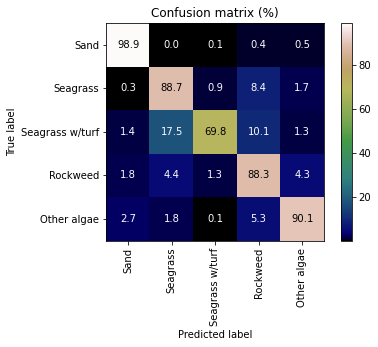

In [39]:
# Show confusion matrix
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
confusion_matrix = sklearn.metrics.confusion_matrix(y_val,y_val_pred,normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix (%)')
plt.show()

The confusion matrix shows overall good performance. As expected, Sand is easy to recognise, while Seagrass w/turf is harder. 

We have now tried parameters:
n_estimators = [1, 5, 10, 15, 20, 25, 30],
max_samples = [0.02, 0.06, 0.1, 0.3, 0.6, 1.0],
min_samples_leaf = [35, 30, 25, 20, 15, 10, 5, 1, 0.01,0.001,0.0001,0.00001,0.000001, 0.0000001]

and found the best model with the parameters:

n_estimators = 20,
max_samples = 0.6
min_samples_leaf = 15
